# Examining the simulation of El Niño-Southern Oscillation (ENSO) in CMIP6 models 

This notebook is created by [Christina Karamperidou](christinakaramperidou.com) for ATMO 449: Intro to Climate Modeling.  

# Introduction

This notebook will assess the simulation of ENSO in CMIP6 models, and examine its changes under greenhouse gas emission scenarios.

## Computational Recipe


*   Read in climate model output stored on Google Cloud and select Sea Surface Temperature (SST) fields from the historical and future climate simulations. 

*   Compute monthly climatology (1981 - 2010), obtain SST anomalies in the NINO3.4 region (NINO3.4 Index), and smooth the anomalies with a 3-month running mean (Oceanic Niño Index).

* Plot the NINO3.4 Index timeseries, and calculate basic NINO3.4 statistics: standard deviation, skewness and spatial pattern. Compare with observations. 

* Calculate and plot the El Niño and La Niña SSTa composites from this model simulation. 

* Calculate the correlation between global and precipitation and the NINO3.4 Index in the CMIP6 model, and compare with observations (aka ENSO teleconnection).

* Calculate ENSO statistics for a future climate scenario and discuss changes in ENSO and its teleconnections under greenhouse gas forcing.

## Import required packages

Import the packages that enable analyzing and plotting climate data. 

We will load the packages using aliases, which is more convenient when typing and calling their functions:


In [1]:
#Importing required packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import cartopy.crs as ccrs
import glob as glob
import netCDF4 as nc
from netCDF4 import Dataset
from scipy.stats import skew,stats
import bottleneck
import gcsfs
import matplotlib.ticker as mticker
import warnings
import scipy.signal as signal
warnings.filterwarnings("ignore") 

------
# Examine ENSO simulation in a CMIP6 coupled model simulation 
------

First, we will load a file containing the list of models and their output that are available in this Google Cloud archive:

In [2]:
#Loading CMIP6 data stored on google cloud
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()       #print the first few rows of the file

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon          ps         gn   
1     Amon        rsds         gn   
2     Amon        rlus         gn   
3     Amon        rlds         gn   
4     Amon         psl         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

We see that the data are organized in a table, with variables corresponding to the CMIP activity (activity_ID), the modeling institution (institution_id), the source of the data (source_id), the experiment (experiment_id), the ensemble member (member_id), the variable realm (table_id), the variable name (variable_id), the type of grid (grid_label), the location on the Google Drive (zstore), and other identifying labels for each dataset.

Next, we will filter this table to only select **monthly skin temperature (ts)** data from the CMIP6 coupled model experiments (CMIP) for historical and future climate. For future climate, we will select the extreme forcing scenario SSP5 8.5.  


In [3]:
#Data Filtering: Historical
df_ts_hist = df.query("(activity_id=='CMIP') & (variable_id == 'ts' ) & (experiment_id == 'historical') & table_id == 'Amon'")
df_ts_hist

activity_id institution_id     source_id experiment_id member_id  \
1018          CMIP      NOAA-GFDL     GFDL-ESM4    historical  r3i1p1f1   
1194          CMIP      NOAA-GFDL     GFDL-ESM4    historical  r2i1p1f1   
9919          CMIP      NOAA-GFDL      GFDL-CM4    historical  r1i1p1f1   
22293         CMIP           IPSL  IPSL-CM6A-LR    historical  r2i1p1f1   
22349         CMIP           IPSL  IPSL-CM6A-LR    historical  r8i1p1f1   
...            ...            ...           ...           ...       ...   
522923        CMIP            MRI    MRI-ESM2-0    historical  r8i1p1f1   
522949        CMIP            MRI    MRI-ESM2-0    historical  r7i1p1f1   
523297        CMIP            MRI    MRI-ESM2-0    historical  r6i1p1f1   
523711        CMIP           CMCC  CMCC-CM2-SR5    historical  r3i1p2f1   
523735        CMIP           CMCC  CMCC-CM2-SR5    historical  r2i1p2f1   

       table_id variable_id grid_label  \
1018       Amon          ts        gr1   
1194       Amon          ts        gr1   
9919       Amon          ts        gr1   
22293      Amon          ts         gr   
22349      Amon          ts         gr   
...         ...         ...        ...   
522923     Amon          ts         gn   
522949     Amon          ts         gn   
523297     Amon          ts         gn   
523711     Amon          ts         gn   
523735     Amon          ts         gn   

                                                   zstore  dcpp_init_year  \
1018    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...             NaN   
1194    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...             NaN   
9919    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...             NaN   
22293   gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...             NaN   
22349   gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...             NaN   
...                                                   ...             ...   
522923  gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...             NaN   
522949  gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...             NaN   
523297  gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...             NaN   
523711  gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...             NaN   
523735  gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...             NaN   

         version  
1018    20180701  
1194    20180701  
9919    20180701  
22293   20180803  
22349   20180803  
...          ...  
522923  20210813  
522949  20210813  
523297  20210907  
523711  20211108  
523735  20211109  

[584 rows x 11 columns]

We found a list of output data that fit the criteria we set in our query.

Below, we select the SSP8.5 scenario output:

In [4]:
#Data Filtering: SSP5 8.5
df_ts_ssp585 = df.query("(activity_id=='ScenarioMIP') & (variable_id == 'ts' ) & (experiment_id == 'ssp585') & table_id == 'Amon'")
df_ts_ssp585

activity_id institution_id    source_id experiment_id member_id  \
840     ScenarioMIP      NOAA-GFDL     GFDL-CM4        ssp585  r1i1p1f1   
18930   ScenarioMIP      NOAA-GFDL    GFDL-ESM4        ssp585  r1i1p1f1   
54498   ScenarioMIP   CNRM-CERFACS   CNRM-CM6-1        ssp585  r1i1p1f2   
66606   ScenarioMIP            BCC  BCC-CSM2-MR        ssp585  r1i1p1f1   
71450   ScenarioMIP   CNRM-CERFACS   CNRM-CM6-1        ssp585  r4i1p1f2   
...             ...            ...          ...           ...       ...   
523273  ScenarioMIP            MRI   MRI-ESM2-0        ssp585  r2i1p1f1   
523316  ScenarioMIP            MRI   MRI-ESM2-0        ssp585  r4i1p1f1   
523340  ScenarioMIP            MRI   MRI-ESM2-0        ssp585  r5i1p1f1   
523401  ScenarioMIP            MRI   MRI-ESM2-0        ssp585  r3i1p1f1   
523426  ScenarioMIP           MOHC  UKESM1-0-LL        ssp585  r4i1p1f2   

       table_id variable_id grid_label  \
840        Amon          ts        gr1   
18930      Amon          ts        gr1   
54498      Amon          ts         gr   
66606      Amon          ts         gn   
71450      Amon          ts         gr   
...         ...         ...        ...   
523273     Amon          ts         gn   
523316     Amon          ts         gn   
523340     Amon          ts         gn   
523401     Amon          ts         gn   
523426     Amon          ts         gn   

                                                   zstore  dcpp_init_year  \
840     gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...             NaN   
18930   gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...             NaN   
54498   gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...             NaN   
66606   gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/s...             NaN   
71450   gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...             NaN   
...                                                   ...             ...   
523273  gs://cmip6/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ss...             NaN   
523316  gs://cmip6/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ss...             NaN   
523340  gs://cmip6/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ss...             NaN   
523401  gs://cmip6/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ss...             NaN   
523426  gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/...             NaN   

         version  
840     20180701  
18930   20180701  
54498   20190219  
66606   20190314  
71450   20190410  
...          ...  
523273  20210907  
523316  20210907  
523340  20210907  
523401  20210907  
523426  20210907  

[283 rows x 11 columns]

We found new instances of output data that fit the criteria we set in our query.

**For this analysis, we will select the model CESM2**. We thus further filter our list, to only include this model for both its historical and SSP5 8.5 simulation:

In [5]:
df_ts = df.query("(activity_id=='CMIP'|activity_id=='ScenarioMIP') & (variable_id == 'ts' ) & (experiment_id == 'historical'|experiment_id == 'ssp585') & table_id == 'Amon' & source_id=='CESM2'")
df_ts

activity_id institution_id source_id experiment_id  member_id  \
59848          CMIP           NCAR     CESM2    historical   r1i1p1f1   
61667          CMIP           NCAR     CESM2    historical   r4i1p1f1   
61801          CMIP           NCAR     CESM2    historical   r5i1p1f1   
62753          CMIP           NCAR     CESM2    historical   r2i1p1f1   
63134          CMIP           NCAR     CESM2    historical   r3i1p1f1   
63318          CMIP           NCAR     CESM2    historical   r6i1p1f1   
64549          CMIP           NCAR     CESM2    historical   r8i1p1f1   
64911          CMIP           NCAR     CESM2    historical   r7i1p1f1   
64932          CMIP           NCAR     CESM2    historical   r9i1p1f1   
66333          CMIP           NCAR     CESM2    historical  r10i1p1f1   
200693         CMIP           NCAR     CESM2    historical  r11i1p1f1   
444811  ScenarioMIP           NCAR     CESM2        ssp585  r11i1p1f1   
444861  ScenarioMIP           NCAR     CESM2        ssp585   r4i1p1f1   
445887  ScenarioMIP           NCAR     CESM2        ssp585  r10i1p1f1   

       table_id variable_id grid_label  \
59848      Amon          ts         gn   
61667      Amon          ts         gn   
61801      Amon          ts         gn   
62753      Amon          ts         gn   
63134      Amon          ts         gn   
63318      Amon          ts         gn   
64549      Amon          ts         gn   
64911      Amon          ts         gn   
64932      Amon          ts         gn   
66333      Amon          ts         gn   
200693     Amon          ts         gn   
444811     Amon          ts         gn   
444861     Amon          ts         gn   
445887     Amon          ts         gn   

                                                   zstore  dcpp_init_year  \
59848   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...             NaN   
61667   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...             NaN   
61801   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...             NaN   
62753   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...             NaN   
63134   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...             NaN   
63318   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...             NaN   
64549   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...             NaN   
64911   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r7...             NaN   
64932   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r9...             NaN   
66333   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...             NaN   
200693  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...             NaN   
444811  gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585...             NaN   
444861  gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585...             NaN   
445887  gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585...             NaN   

         version  
59848   20190308  
61667   20190308  
61801   20190308  
62753   20190308  
63134   20190308  
63318   20190308  
64549   20190311  
64911   20190311  
64932   20190311  
66333   20190313  
200693  20190514  
444811  20200528  
444861  20200528  
445887  20200528

We see from the table above, that there are multiple runs with this model and scenario. We will select (randomly) the **first run for the historical experiment (r1i1p1f1)**, and the **fourth run from the SSP5 8.5 scenario (r4i1p1f1)**.



---


## Load SST data from the historical and future simulations.

---



The code below is specific to the way that these data are archived on the Google Cloud. 

Alternatively, we could have downloaded the data files from the CMIP archive and simply load them using the commands from our previous Colab notebooks for reading netcdf files. 

In [6]:
# get the path to a specific zarr store (the first one from the dataframe above)
ts_store_present = df_ts.zstore.values[0]  #this is the row from the table above that corresponds to the first historical run with CESM2. Reminder: python starts counting at 0
ts_store_future = df_ts.zstore.values[12] #this is the row from the table above that corresponds to the fourth ssp 585 CESM2 run. Reminder: python starts counting at 0
print(ts_store_present)                   #print the datasets we selected to ensure it is the correct one
print(ts_store_future)
# create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(ts_store_present)
mapper2 = fsspec.get_mapper(ts_store_future)
# open it using xarray and zarr
dts_present = xr.open_zarr(mapper, consolidated=True)
dts_future = xr.open_zarr(mapper2, consolidated=True)

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/ts/gn/v20190308/
gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r4i1p1f1/Amon/ts/gn/v20200528/


**IMPORTANT:** The order by which the files appear in the list may change overtime, as more runs are added to the database. Thus, we should always inspect the output of the print command to make sure we are indeed reading in the datasets that we want (in this case r1i1p1f1 from the historical simulations, and r4i1p1f1 from the SSP58.5 simulations)

We have loaded the two datasets, and now we will read in the surface temperature (ts) variable from both. 
As you can see from the variable description in the CMIP6_standard_output.xls file from previous modules, skin temperature corresponds to Sea Surface Temperature (SST) over the oceans and surface air temperature over land.

Next, we will load the temperature data and convert units to degrees Celsius (from Kelvin)

In [7]:
#Loading precipitation data and converting units to degrees Celsius
ts_present = dts_present.ts -273.14           #converting units to degrees Celsius
ts_present.attrs = dts_present.ts.attrs       # copy the variable attributes (metadata) from the original ts variable
ts_present.attrs ['units'] = 'Celsius'         # change the units in the metadata to degrees Celsius
ts_present

<xarray.DataArray 'ts' (time: 1980, lat: 192, lon: 288)>
dask.array<sub, shape=(1980, 192, 288), dtype=float32, chunksize=(600, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Surface temperature (skin for open ocean)
    description:    Surface temperature (skin for open ocean)
    frequency:      mon
    id:             ts
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Surface Temperature
    type:           real
    units:          Celsius
    variable_id:    ts

Let's take a quick look to ensure that the data were read correctly and the unit conversion was succesful. 

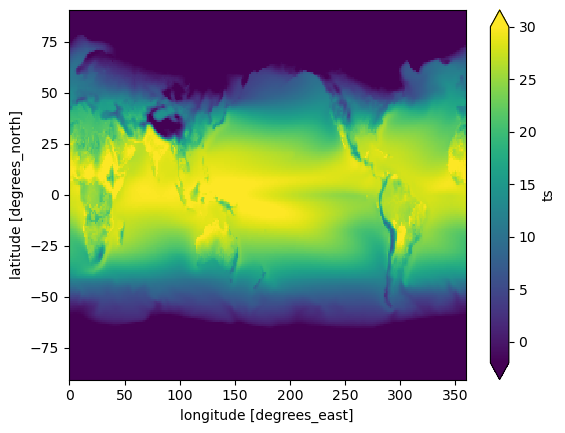

In [8]:
ts_present.mean(dim='time').plot(vmin=-2, vmax=30) 



---


## Compute climatological SST

---



We want to select the period from Jan 1981 to Dec 2010 to compute the climatological SST.
>> **Note:** Remember that this model run does not have a calendar. A historical run uses the historical forcings during the 20th-21st century (i.e., greenhouse gas concentration trends, aerosols, volcanic and solar forcing), but its variability is still internally generated. This means that Years 1981-2010 in the model simulation are not expected to match the variability that was observed during this period, but they are expected to match the trends and mean climate of this period. 


In [9]:
ts_for_clim=ts_present.sel(time=slice('1981-01-01','2010-12-01'))
ts_for_clim

<xarray.DataArray 'ts' (time: 359, lat: 192, lon: 288)>
dask.array<getitem, shape=(359, 192, 288), dtype=float32, chunksize=(228, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1981-01-15 12:00:00 ... 2010-11-15 00:00:00
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Surface temperature (skin for open ocean)
    description:    Surface temperature (skin for open ocean)
    frequency:      mon
    id:             ts
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Surface Temperature
    type:           real
    units:          Celsius
    variable_id:    ts

Now, we can compute the monthly climatology. We group the values by month and then compute the mean for each month. Notice how the resulting climatological SST (named here "ts_clim") has time dimension 12. 

In [10]:
ts_clim = ts_for_clim.groupby('time.month').mean(dim='time')
ts_clim

<xarray.DataArray 'ts' (month: 12, lat: 192, lon: 288)>
dask.array<stack, shape=(12, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Surface temperature (skin for open ocean)
    description:    Surface temperature (skin for open ocean)
    frequency:      mon
    id:             ts
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Surface Temperature
    type:           real
    units:          Celsius
    variable_id:    ts

We can quickly plot a couple of climatological mean SST maps to check that everything is OK in our calculations. 

>> Reminder: In Python, we start counting at zero. Therefore, the first month (January) will have the index 0 in our data array, while the twelvth month (December) will have the index 11. 

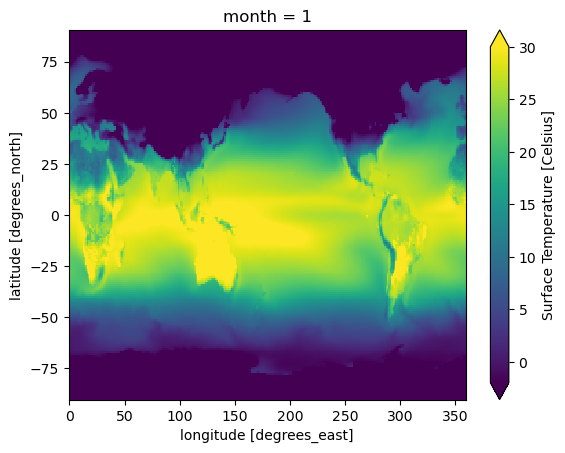

In [11]:
ts_clim[0].plot(vmin=-2, vmax=30)                       #this is January 

---------------
## Compute and plot SST anomalies in the NINO3.4 region
--------------

In [12]:
sst_anom = ts_present.groupby('time.month') - ts_clim
sst_anom

<xarray.DataArray 'ts' (time: 1980, lat: 192, lon: 288)>
dask.array<sub, shape=(1980, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [13]:
# Now compute sst anomalies in the NINO3.4 region
ssta_nino34 = sst_anom.sel(lat=slice(-5, 5), lon=slice(190, 240))

The NINO3.4 Index is defined as the average SST anomaly in the NINO3.4 box, therefore to compute the index, we will average along the latitude and longitude dimensions. 

We will also smooth the anomalies using a 3-month running mean, to avoid any noisy spikes in the data. The 3-month running mean of the NINO3.4 Index is also known as the Oceanic Niño Index (ONI), as defined opearationally by NOAA. 

In [14]:
ssta_nino34_mean = ssta_nino34.mean(dim=('lon', 'lat'))
oni = ssta_nino34_mean.rolling(time=3).mean(dim='time')
oni

<xarray.DataArray 'ts' (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

Now we can plot the 3-month running mean NINO3.4 Index, and use red colors to indicate El Niño events (NINO3.4>0.5) and blue colors to indicate La Niña events (NINO3.4<-0.5). 

In order to plot the dates on the x-axis, we will turn the datetime coordinates into a sequence of the year fraction. (This is just one of the many different ways to do this in python)

Note that this is necessary here because of the extra features we want to have to make the plot nice, like filling in with blue and red color for La Nina and El Nino conditions. 
Normally, you wouldn't need to create a year-fraction time series for the x-axis, you would just plot the ONI time series in simpler ways (like oni.plot()).

In [15]:
def time_fraction(ds):    #creates a function that turns a timedate object to a year-fraction sequence. 
    start_date = ds.time[0].astype('str').values ; start_year = int(str(start_date)[:4]) ; start_month=int(str(start_date)[5:7])   # extract the start year and start month
    end_date = ds.time[-1].astype('str').values ; end_year = int(str(end_date)[:4]) ; end_month=int(str(end_date)[5:7])            # extract the end year and end month
    fraction=np.arange(0,1,1/12)
    return np.arange(start_year+fraction[start_month-1],end_year+fraction[end_month-1]+1/14,1/12)                                  # create a sequence of year fractions

In [16]:
xrange = time_fraction(dts_present)                      #define the x axis (time in months). Time starts in [start year, start month] and ends in [end year, end month] in monthly time steps i.e. 1/12 of the year)

In [ ]:
# plot the ONI time series
plt.clf()
fig = plt.subplots(figsize=(20,5))              #create the figure
y = oni                                         #define the y axis (ONI)
x_limits = [min(xrange), max(xrange)]           #define the limits (range of values) of the x axis
y_limits = [-4.0, 4.0]                          #define the limits (range of values) of the y axis
el_nino_threshold = 0.5                         #define the threshold above which an El Niño event occurs (in degrees Celsius)
plt.xlim(x_limits)                              #plot the x axis with its limits
plt.ylim(y_limits)                              #plot the y axis with its limits
plt.xticks(fontsize=16)                         #define the font size for the tick marks
plt.yticks(fontsize=16)
plt.plot(xrange, y,c='black')                   #plot y vs. x, color the line black 
plt.plot(x_limits, [el_nino_threshold, el_nino_threshold], c='r') #plot a red line to show the El Nino threshold
plt.plot(x_limits, [-el_nino_threshold, -el_nino_threshold], c='b') #plot a blue line to show the La Nina threshold
plt.fill_between(xrange, el_nino_threshold, y, color='red', where=y>=el_nino_threshold, interpolate=True) #fill in the space between the threshold line and the NINO3.4 line with red color to show the El Nino events 
plt.fill_between(xrange, -el_nino_threshold, y, color='blue', where=y<=-el_nino_threshold, interpolate=True)  #same for La Nina
plt.xlabel("Year",fontsize=18)                              #set the x axis label 
plt.ylabel("NINO3.4 SSTA ($^{\circ}$C)",fontsize=18)        #set the y axis label
plt.title("NINO3.4 SST anomaly, CESM2-historical",fontsize=18) #set the title of the plot
plt.savefig('NINO34_CESM2historical.pdf')                 #save the figure in the working directory

--------
## Compute ENSO statistics in the model's historical simulation
----------------

Next, we will compute some of the main features of ENSO, as we discussed them in the lecture. 

First, we will compute the **standard deviation** and **skewness** of the NINO3.4 Index, and then we will create **composite plots** of El Niño and La Niña events. 

In [ ]:
print( 'The standard deviation of the NINO3.4 Index in this model is %0.2f' %ssta_nino34_mean.std('time'), 'and its skewness is %0.2f' %skew(ssta_nino34_mean))

> **Question 1:** Compare the ENSO simulation in this model with the observed (**from your Week 6 Assignment**). You can comment on the statistics calculated above, as well as on the time series plots and other features you notice.  

> **Question 2:** Does the model simulate the El Niño events of years 1982-83, 1997-98, and 2015-16? Why, or why not?

--------
## Create ENSO composites
----------------

Now, we will select all the El Niño and La Niña events in the SST anomaly array, and plot their **composite**. In other words, we will plot the average pattern of SST anomalies during El Niño or La Niña events. 

To identify the events, we will create a "label" for each monthly SST anomaly, which will indicate if its value satisfies the criteria for El Niño or La Niña events. 

>> Reminder: An El Niño event occurs when the ONI (or smoothed NINO3.4 SST anomaly) is above 0.5 ºC. A La Niña event occurs when the ONI (or smoothed NINO3.4 SST anomaly) is below -0.5 ºC. 

In [ ]:
# create a categorical  dataarray
oni=oni.load()    # oni is a dask array, load as an xarray to use of indexing below. 
nino34labels = xr.full_like(oni, 'none', dtype='U4')
nino34labels[oni > 0.5] = 'nino'
nino34labels[oni <= -0.5] = 'nina'
nino34labels.rename('label')                      #rename the variable 

In [ ]:
# average SST anomalies based on their label (nino, nina or none)
sst_composites = sst_anom.groupby(nino34labels.rename('label')).mean(dim='time')  
sst_composites 

In [ ]:
# Now select the average for the label: nino. In other words, this is the composite SST anomaly for all months with El Niño conditions in the record. 
nino_composite=sst_composites.sel(label='nino')
# Repeat for La Niña conditions: 
nina_composite=sst_composites.sel(label='nina')
nina_composite

In [ ]:
# Plot the El Nino composite: 
lon=nino_composite.lon
lat=nino_composite.lat
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(-3, 3, 0.25)
# filled contours
cf = ax.contourf(lon, lat, nino_composite, cmap='bwr',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, nino_composite, colors='k', linewidths=1,levels=levels,
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=10, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('', fontsize=14)
cb.set_label(u'\N{DEGREE SIGN}C', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('composite SST anomaly, El Niño events', loc='left', fontsize=26)
plt.title('CESM2, historical', loc='right', fontsize=18)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 140, 160, 180, -160, -140, -120, -100, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}
#ax.plot(22.9444,40.6401,  markersize=20, marker='*', color='red',transform=ccrs.PlateCarree(),alpha=1)  # this is a way to add a marker on the plot. Put a marker for your hometown!  # 
plt.savefig('ElNinoComposite_CESM2historical.pdf')  
plt.show()

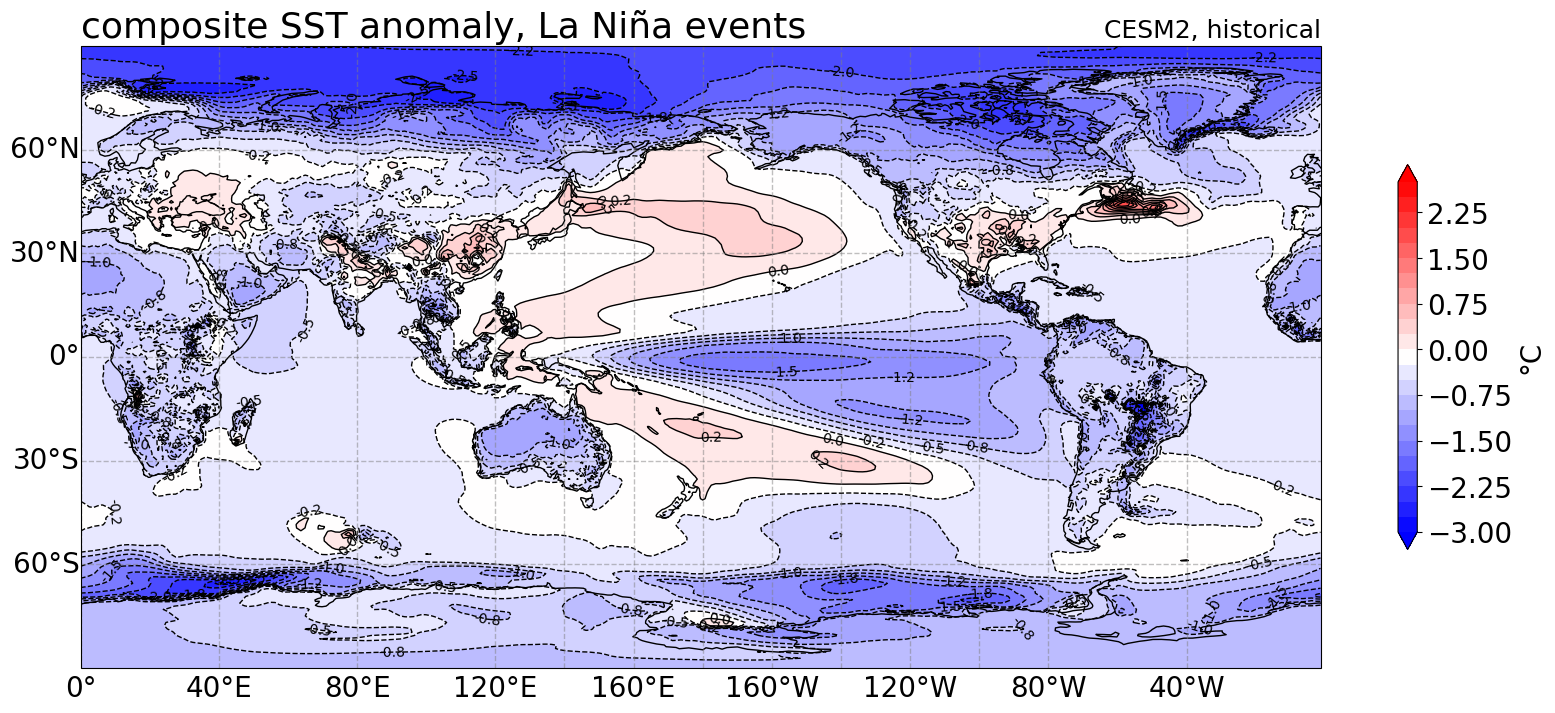

In [23]:
# Plot the La Nina composite 
lon=nina_composite.lon
lat=nina_composite.lat
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(-3, 3, 0.25)
# filled contours
cf = ax.contourf(lon, lat, nina_composite, cmap='bwr',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, nina_composite, colors='k', linewidths=1,levels=levels,
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=10, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('', fontsize=14)
cb.set_label(u'\N{DEGREE SIGN}C', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('composite SST anomaly, La Niña events', loc='left', fontsize=26)
plt.title('CESM2, historical', loc='right', fontsize=18)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 140, 160, 180, -160, -140, -120, -100, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}
#ax.plot(22.9444,40.6401,  markersize=20, marker='*', color='red',transform=ccrs.PlateCarree(),alpha=1)  # put a marker for your hometown!
plt.savefig('LaNinaComposite_CESM2historical.pdf')  
plt.show()

We see positive SST anomalies in the east and central Pacific when we have an El Niño event, and negative SST anomalies when we have a La Niña event. 

Note that here, we use ts (skin temperature) instead of SST like we did for observations in Week6. TS corresponds to SST over the oceans, and 2m temperature over land.

> **Question 3:** Compare the composite SST anomalies during El Niño and La Niña in the model simulation (plotted above) with the observed patterns (**from your Week 6 Assignment**). What are the main similarities and differences that you observe? 

----------------------
# ENSO impacts (precipitation teleconnections) in a CMIP6 coupled model simulation

Next, we will study the impacts of ENSO on precipitation. In other words, we will study **ENSO teleconnections** with precipitation in this model simulation.  

We will do that by computing the correlation of the NINO3.4 Index with gridded precipitation datasets over land, for various regions. 

First, we will read in the precipitation output from the model simulation. 

>> **Note:** We need to be careful to select the same simulation as with the SST data (i.e., if we previously selected the first run (r1i1p1f1), then we need to ensure we select the same simulation for precipitation. 



---


## Load precipitation data from the historical and future simulations.

---



In [24]:
df_pr = df.query("(activity_id=='CMIP'|activity_id=='ScenarioMIP') & (variable_id == 'pr' ) & (experiment_id == 'historical'|experiment_id == 'ssp585') & table_id == 'Amon' & source_id=='CESM2'")
df_pr

activity_id institution_id source_id experiment_id  member_id  \
69312          CMIP           NCAR     CESM2    historical   r5i1p1f1   
69313          CMIP           NCAR     CESM2    historical   r3i1p1f1   
69387          CMIP           NCAR     CESM2    historical   r7i1p1f1   
69389          CMIP           NCAR     CESM2    historical   r1i1p1f1   
69399          CMIP           NCAR     CESM2    historical   r4i1p1f1   
69440          CMIP           NCAR     CESM2    historical   r2i1p1f1   
69455          CMIP           NCAR     CESM2    historical   r8i1p1f1   
69458          CMIP           NCAR     CESM2    historical   r6i1p1f1   
200657         CMIP           NCAR     CESM2    historical  r11i1p1f1   
409588         CMIP           NCAR     CESM2    historical  r10i1p1f1   
409593         CMIP           NCAR     CESM2    historical   r9i1p1f1   
444345  ScenarioMIP           NCAR     CESM2        ssp585   r4i1p1f1   
444743  ScenarioMIP           NCAR     CESM2        ssp585  r11i1p1f1   
446430  ScenarioMIP           NCAR     CESM2        ssp585  r10i1p1f1   

       table_id variable_id grid_label  \
69312      Amon          pr         gn   
69313      Amon          pr         gn   
69387      Amon          pr         gn   
69389      Amon          pr         gn   
69399      Amon          pr         gn   
69440      Amon          pr         gn   
69455      Amon          pr         gn   
69458      Amon          pr         gn   
200657     Amon          pr         gn   
409588     Amon          pr         gn   
409593     Amon          pr         gn   
444345     Amon          pr         gn   
444743     Amon          pr         gn   
446430     Amon          pr         gn   

                                                   zstore  dcpp_init_year  \
69312   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...             NaN   
69313   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...             NaN   
69387   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r7...             NaN   
69389   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...             NaN   
69399   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...             NaN   
69440   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...             NaN   
69455   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...             NaN   
69458   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...             NaN   
200657  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...             NaN   
409588  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...             NaN   
409593  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r9...             NaN   
444345  gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585...             NaN   
444743  gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585...             NaN   
446430  gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585...             NaN   

         version  
69312   20190401  
69313   20190401  
69387   20190401  
69389   20190401  
69399   20190401  
69440   20190401  
69455   20190401  
69458   20190401  
200657  20190514  
409588  20200124  
409593  20200124  
444345  20200528  
444743  20200528  
446430  20200528

**Attention:** We know that each run (denoted by r1,r2 etc) has its own internal variability. Here, we will correlate the NINO34 index that we calculated using skin temperature data (ts) with precipitation. **We need to ensure we select output from the same run of the model**.

In [25]:
# get the path to a specific zarr store (the first one from the dataframe above)
pr_store_present = df_pr.zstore.values[3]  #this is the row from the table above that corresponds to our selected historical run. Reminder: python starts counting at 0
pr_store_future = df_pr.zstore.values[11] #this is the row from the table above that corresponds to our selected ssp585 run. Reminder: python starts counting at 0
print(pr_store_present)
print(pr_store_future)
# create a mutable-mapping-style interface to the store
mapper_pr = fsspec.get_mapper(pr_store_present)
mapper2_pr = fsspec.get_mapper(pr_store_future)
# open it using xarray and zarr
dpr_present = xr.open_zarr(mapper_pr, consolidated=True)
dpr_future = xr.open_zarr(mapper2_pr, consolidated=True)

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/pr/gn/v20190401/
gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r4i1p1f1/Amon/pr/gn/v20200528/


We have loaded the two datasets, and now we will read in the precipition (pr) variable from both, and we will convert units to mm/day. 
>> 1 kg of rain water spread over 1 square meter of surface is 1 mm in thickness; there are 60X60X24=86400 seconds in one day. Therefore, 1 kg/m2/s = 86400 mm/day.

In [26]:
#Loading precipitation data and converting units to mm/day
pr_present = dpr_present.pr *86400           #converting units to mm/day
pr_present.attrs = dpr_present.pr.attrs       # copy the variable attributes (metadata) from the original pr variable
pr_present.attrs ['units'] = 'mm/day'         # change the units in the metadata to mm/day
pr_present

<xarray.DataArray 'pr' (time: 1980, lat: 192, lon: 288)>
dask.array<mul, shape=(1980, 192, 288), dtype=float64, chunksize=(600, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        at surface; includes both liquid and solid phases from al...
    description:    at surface; includes both liquid and solid phases from al...
    frequency:      mon
    id:             pr
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Precipitation
    type:           real
    units:          mm/day
    variable_id:    pr

Let's take a quick look to ensure that the data were read correctly and the unit conversion was succesful. 

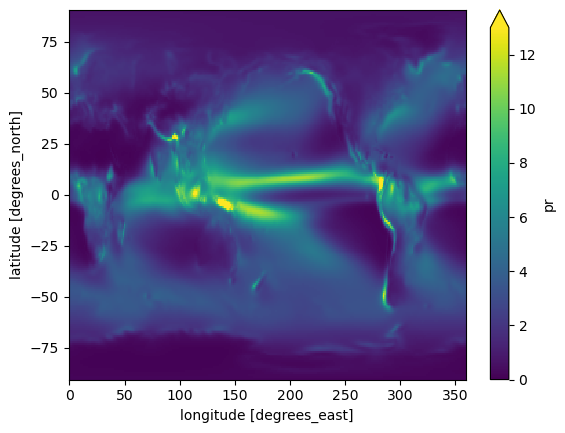

In [27]:
pr_present.mean(dim='time').plot(vmin=0, vmax=13) 

In [28]:
# compute climatology and anomalies
precip_for_clim=pr_present.sel(time=slice('1981-01-01','2010-12-01'))
precip_for_clim
precip_clim = precip_for_clim.groupby('time.month').mean(dim='time')
precip_clim
precip_anom = pr_present.groupby('time.month') - precip_clim
precip_anom

<xarray.DataArray 'pr' (time: 1980, lat: 192, lon: 288)>
dask.array<sub, shape=(1980, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12


We will compute the correlation in time between the 3-month running mean NINO3.4 Index (ONI) and the gridded precipitation output from the same simulation. 

In [29]:
precip_cor = xr.corr(precip_anom,oni,dim='time')                     # calculate the correlation between precipitation anomalies and ONI
precip_cor                                                                 # the resulting array containing the correlation coefficients

<xarray.DataArray (lat: 192, lon: 288)>
dask.array<truediv, shape=(192, 288), dtype=float64, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

As you can see, the resulting array is a lat x lon array. Each gridcell contains the value of the correlation coefficient between the ONI time series and the precipitation time series for that particular gridcell.

## Plot the correlation 

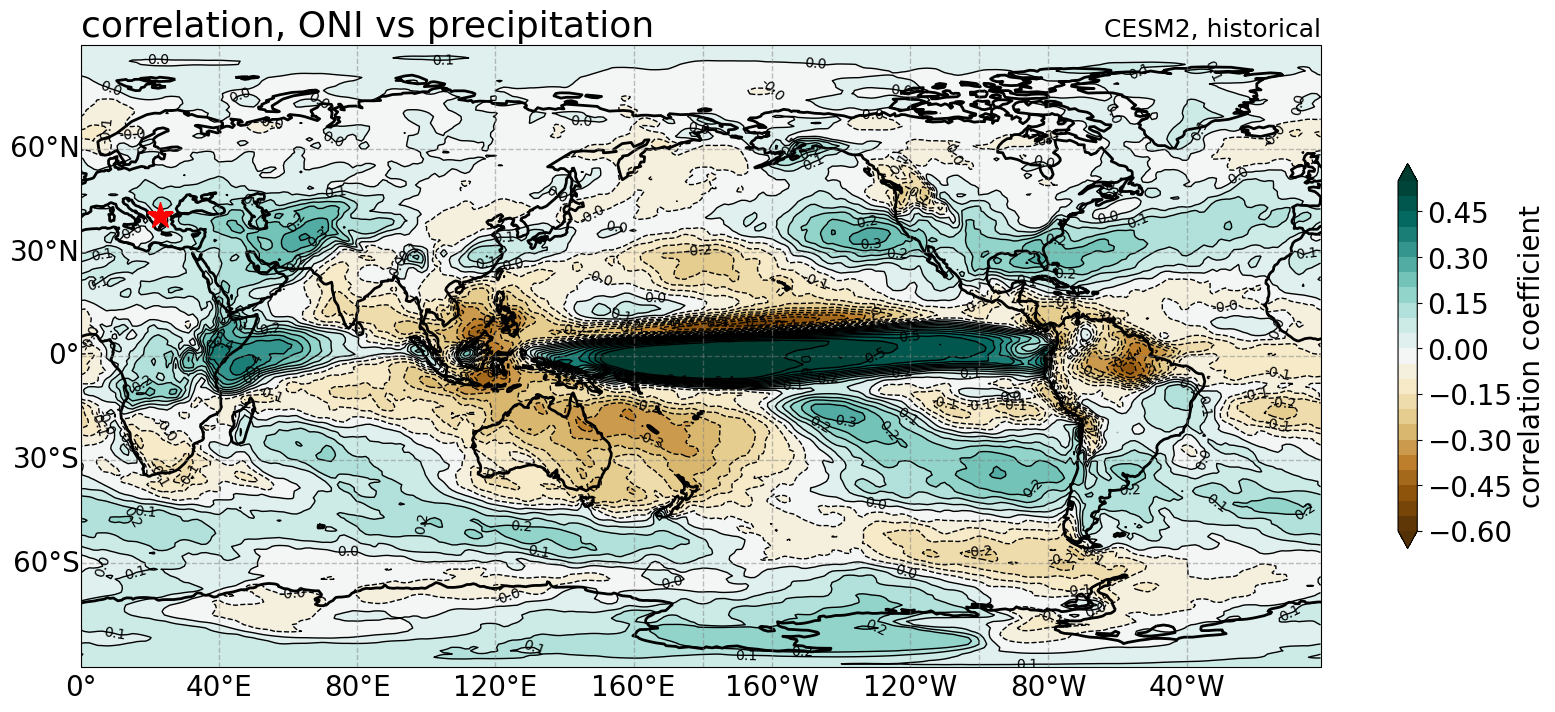

In [30]:
# Plot the correlation map: 
lon=precip_cor.lon
lat=precip_cor.lat
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(-0.6, 0.6, 0.05)
# filled contours
cf = ax.contourf(lon, lat, precip_cor, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, precip_cor, colors='k', linewidths=1,levels=levels,
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=10, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('', fontsize=14)
cb.set_label('correlation coefficient', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('correlation, ONI vs precipitation', loc='left', fontsize=26)
plt.title('CESM2, historical', loc='right', fontsize=18)
ax.coastlines(linewidth=2)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 160, 180, -160, -120, -100, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}
ax.plot(22.9444,40.6401,  markersize=20, marker='*', color='red',transform=ccrs.PlateCarree(),alpha=1)  # this is a way to add a marker on the plot. Put a marker for your hometown!  # 
plt.savefig('ENSO_precipitation_correlation_CESM2_historical.pdf')  
plt.show()

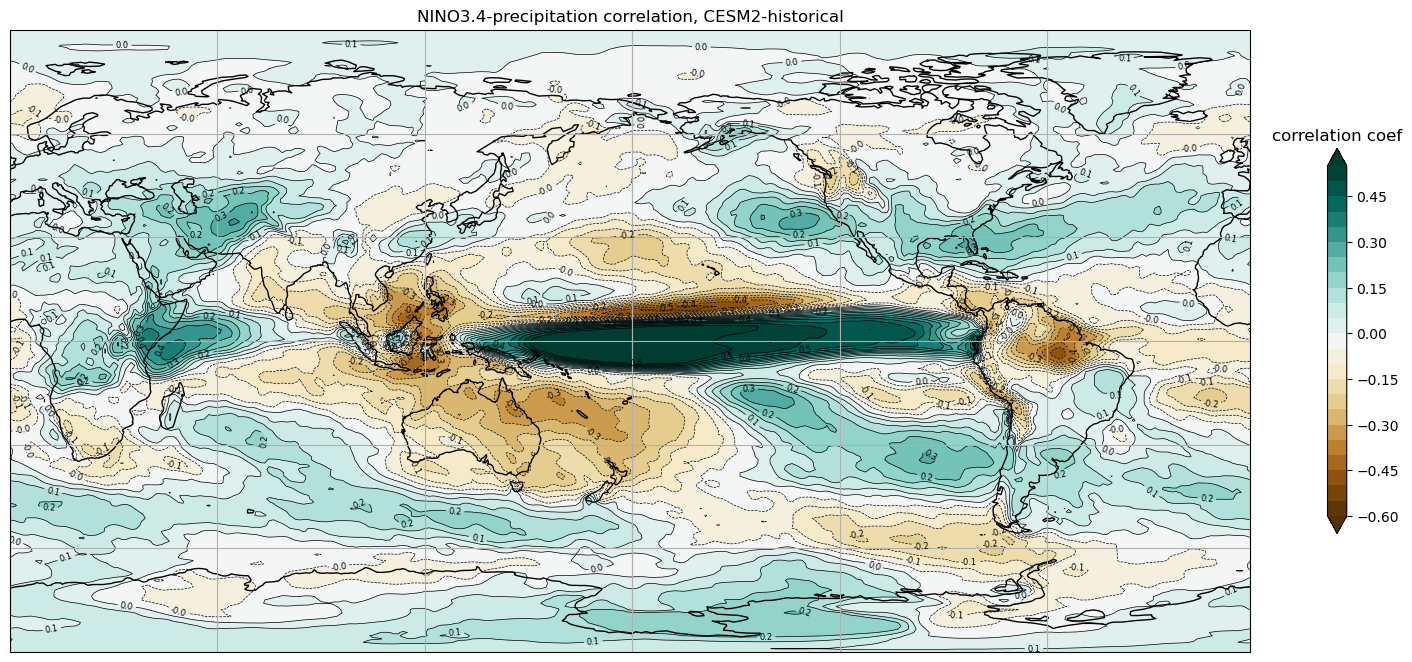

In [31]:
lon=precip_cor.lon
lat=precip_cor.lat
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(-0.6, 0.6, 0.05)
# filled contours
cf = ax.contourf(lon, lat, precip_cor, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, precip_cor, colors='k', linewidths=0.5,levels=levels,
                transform=ccrs.PlateCarree())

# add contour labels
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%0.1f');


# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('correlation coef')
ax.set_title('NINO3.4-precipitation correlation, CESM2-historical');
ax.coastlines()
ax.gridlines()


In the above plot, the green colors indicate positive correlation between ENSO and precipitation. This means that when the ONI is positive (i.e., when there is an El Niño event) then precipitation in that area is increased. 

On the contrary, in regions where correlation is negative (brown colors), when there is an El Niño event, precipitation is decreased in the area. 

> **Question 4:** How good is this model's performance in simulating ENSO teleconnections with precipitation (i.e., the relationship between ENSO and precipitation)? In other words, what major similarities and discrepancies do you see in this plot compared to the observed plot from the Week 6? 

------
# SSP5 8.5: Examine ENSO simulation in a CMIP6 coupled model simulation of future climate 
------

Now, to answer the questions in **Part II** of your Week 11 Assignment, you are asked to repeat the above analysis of ENSO, but for the SSP5 8.5 simulation from this model (CESM2).

>> The datasets your will use are **dts_future** and **dpr_future**. To compute climatology for the SSP5 8.5 simulation, use the whole run (from 2015 to 2100). For all calculations, temperature and precipitation need to be **de-trended** prior to calculations. 

For **Part II: Question 5**, you are asked to upload your new plots (NINO3.4 timeseries, El Niño and La Niña composites, and ENSO teleconnection plot). Combine them in a single pdf or powerpoint file. 

For **Part II: Questions 6-8**, you are asked to describe your plots and comment on the changes in ENSO that this model projects for the SSP5 8.5 scenario. 


Below, I give you the code to calculate the sst anomalies and the ONI Index for the future run. Follow the instructions below it to complete the assignment. 



---


## Load SST data from the future climate simulation.

---



In [32]:
#Loading precipitation data and converting units to degrees Celsius
ts_future = dts_future.ts -273.14           #converting units to degrees Celsius
ts_future.attrs = dts_future.ts.attrs       # copy the variable attributes (metadata) from the original ts variable
ts_future.attrs ['units'] = 'Celsius'         # change the units in the metadata to degrees Celsius
ts_future

<xarray.DataArray 'ts' (time: 1032, lat: 192, lon: 288)>
dask.array<sub, shape=(1032, 192, 288), dtype=float32, chunksize=(404, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        TS
    description:    Surface temperature (skin for open ocean)
    frequency:      mon
    id:             ts
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Surface Temperature
    type:           real
    units:          Celsius
    variable_id:    ts

The SSP5 8.5 simulation has a temperature trend, since it is a simulation with strong external greenhouse has forcing. ENSO is an anomaly phenomenon. 
Therefore, before computing the ENSO sst anomalies, we need to **detrend** the temperature data in order to remove the linear trend. 

In [33]:
ts_future=ts_future.load()
ts_future_detrend_data=signal.detrend(ts_future)      # detrend the temperature data
ts_future_detrend=ts_future.copy(data=ts_future_detrend_data) #create a new dataset, fill in with the detrended data.
ts_future_detrend=ts_future_detrend+ts_future.mean(dim='time')    #we add the mean to the detrended data

>> **Now we will use the detrended temperature data (ts_future_detrend) to repeat the analysis of the historical run, in order to examine ENSO simulation in this model's SSP5 8.5 run.** You copy the code used for the historical simulation, and replace the datasets with the future detrended datasets. 

>> **We will also need to detrend the precipitation data as well (by adapting the code above).** 



---


## Compute climatological SST (future)

---



We want to select the entire future run to compute the climatological SST.


In [34]:
ts_for_clim_future=ts_future_detrend

Now, we can compute the monthly climatology. We group the values by month and then compute the mean for each month. Notice how the resulting climatological SST (named here "ts_clim") has time dimension 12. 

In [35]:
ts_clim_future = ts_for_clim_future.groupby('time.month').mean(dim='time')

We can quickly plot a couple of climatological mean SST maps to check that everything is OK in our calculations. 

>> Reminder: In Python, we start counting at zero. Therefore, the first month (January) will have the index 0 in our data array, while the twelvth month (December) will have the index 11. 

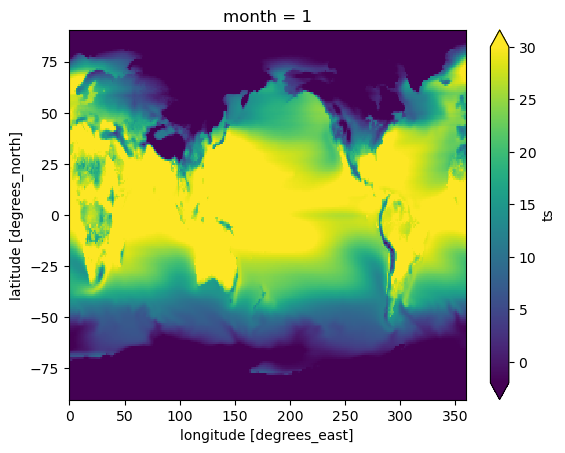

In [36]:
ts_clim_future[0].plot(vmin=-2, vmax=30)                       #this is January 

---------------
## Compute and plot SST anomalies in the NINO3.4 region (future)
--------------

In [37]:
sst_anom_future = ts_future_detrend.groupby('time.month') - ts_clim_future

In [38]:
# Now compute sst anomalies in the NINO3.4 region
ssta_nino34_future = sst_anom_future.sel(lat=slice(-5, 5), lon=slice(190, 240))

The NINO3.4 Index is defined as the average SST anomaly in the NINO3.4 box, therefore to compute the index, we will average along the latitude and longitude dimensions. 

We will also smooth the anomalies using a 3-month running mean, to avoid any noisy spikes in the data. The 3-month running mean of the NINO3.4 Index is also known as the Oceanic Niño Index (ONI), as defined opearationally by NOAA. 

In [39]:
ssta_nino34_mean_future = ssta_nino34_future.mean(dim=('lon', 'lat'))
oni_future = ssta_nino34_mean_future.rolling(time=3).mean(dim='time')
oni_future

<xarray.DataArray 'ts' (time: 1032)>
array([        nan,         nan, -0.3475257 , ..., -0.7326523 ,
       -0.65470773, -0.50194573], dtype=float32)
Coordinates:
  * time     (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

Now we can plot the 3-month running mean NINO3.4 Index, and use red colors to indicate El Niño events (NINO3.4>0.5) and blue colors to indicate La Niña events (NINIO3.4<-0.5). 

In [40]:
def time_fraction(ds):    #creates a function that turns a timedate object to a year-fraction sequence. 
    start_date = ds.time[0].astype('str').values ; start_year = int(str(start_date)[:4]) ; start_month=int(str(start_date)[5:7])   # extract the start year and start month
    end_date = ds.time[-1].astype('str').values ; end_year = int(str(end_date)[:4]) ; end_month=int(str(end_date)[5:7])            # extract the end year and end month
    fraction=np.arange(0,1,1/12)
    return np.arange(start_year+fraction[start_month-1],end_year+fraction[end_month-1]+1/14,1/12)                                  # create a sequence of year fractions

In [41]:
xrange = time_fraction(dts_future)                      #define the x axis (time in months). Time starts in [start year, start month] and ends in [end year, end month] in monthly time steps i.e. 1/12 of the year)

<Figure size 640x480 with 0 Axes>

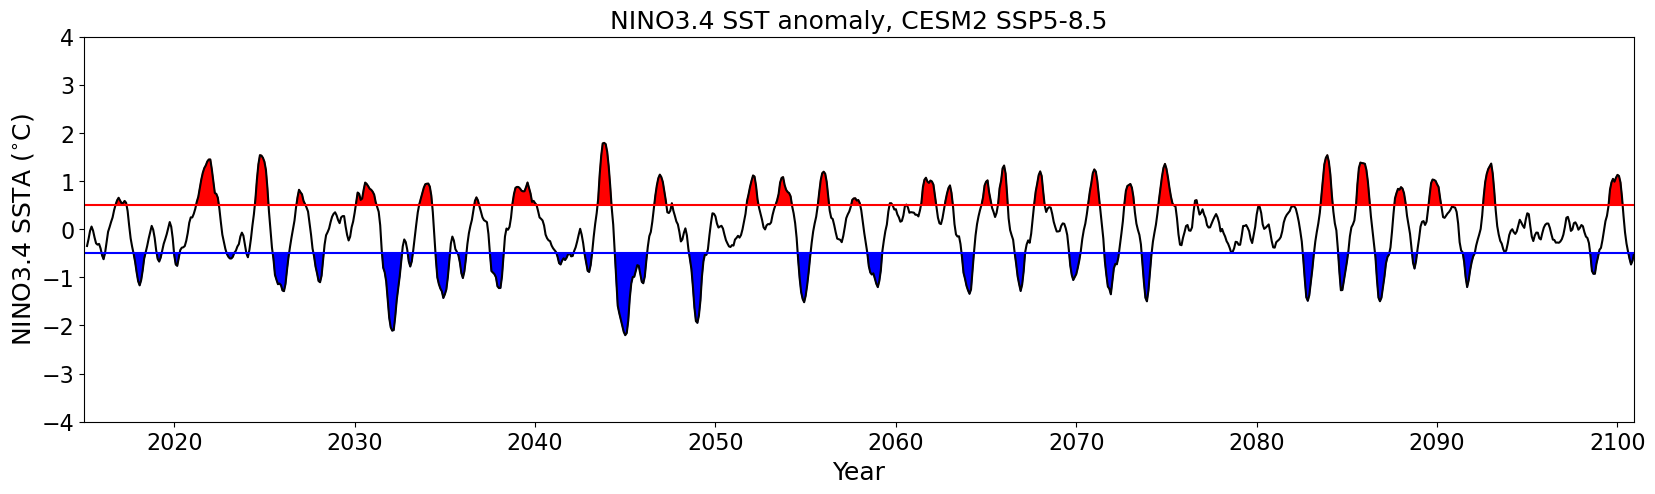

In [42]:
# plot the ONI time series (future)
plt.clf()
fig = plt.subplots(figsize=(20,5))              #create the figure
y = oni_future                                         #define the y axis (ONI)
x_limits = [min(xrange), max(xrange)]           #define the limits (range of values) of the x axis
y_limits = [-4.0, 4.0]                          #define the limits (range of values) of the y axis
el_nino_threshold = 0.5                         #define the threshold above which an El Niño event occurs (in degrees Celsius)
plt.xlim(x_limits)                              #plot the x axis with its limits
plt.ylim(y_limits)                              #plot the y axis with its limits
plt.xticks(fontsize=16)                         #define the font size for the tick marks
plt.yticks(fontsize=16)
plt.plot(xrange, y,c='black')                   #plot y vs. x, color the line black 
plt.plot(x_limits, [el_nino_threshold, el_nino_threshold], c='r') #plot a red line to show the El Nino threshold
plt.plot(x_limits, [-el_nino_threshold, -el_nino_threshold], c='b') #plot a blue line to show the La Nina threshold
plt.fill_between(xrange, el_nino_threshold, y, color='red', where=y>=el_nino_threshold, interpolate=True) #fill in the space between the threshold line and the NINO3.4 line with red color to show the El Nino events 
plt.fill_between(xrange, -el_nino_threshold, y, color='blue', where=y<=-el_nino_threshold, interpolate=True)  #same for La Nina
plt.xlabel("Year",fontsize=18)                              #set the x axis label 
plt.ylabel("NINO3.4 SSTA ($^{\circ}$C)",fontsize=18)        #set the y axis label
plt.title("NINO3.4 SST anomaly, CESM2 SSP5-8.5",fontsize=18) #set the title of the plot
plt.savefig('NINO34_CESM2future.pdf')                 #save the figure in the working directory

In [43]:
# Copy here the code that computes standard deviation and skewness of the ONI index in the historical run, replace the historical ONI with the future ONI, and answer the question.
print( 'The standard deviation of the NINO3.4 Index in this model is %0.2f' %ssta_nino34_mean_future.std('time'), 'and its skewness is %0.2f' %skew(ssta_nino34_mean_future))

The standard deviation of the NINO3.4 Index in this model is 0.73 and its skewness is -0.26


**Now you can continue adapting the present-day code to future in order to reproduce the analysis and answer the questions in your assignment**

> Do not forget to detrend the precipitation data before you compute their correlation with NINO3.4. 

**Question #6 asks you about the changes in ENSO statistics that this model projects, and also asks you to comment on any changes in ENSO features you can infer from the NINO3.4 Index timeseries of the future simulation.**

First, the section above calculates for you the ONI (smoothed NINO3.4 Index) from the future simulation. So, use the figure above to comment on changes you see in the ENSO features. 

For calculating changes in ENSO statistics (standard deviation and skewness), you need to find the code that compute these statistics in the historical run, copy it below, replace the historical ONI with the future ONI, and answer the question. 

## Create ENSO composites (future)

Take the code that was used to create ENSO composites in the historical run, copy it below, and replace the ONI and sst anomaly fields from the historical run with the ONI and sst anomalies from the future run, in order to compute the El Nino and La Nina composites from the future run. 

**Using these composites, you can answer Question 7 (Part 2) of your assignment**. 

In [74]:
# first create a categorical  dataarray to put the labels for el nino and la nina corresponding to your future run
oni_future=oni_future.load()    # oni is a dask array, load as an xarray to use of indexing below. 
nino34labels_future = xr.full_like(oni_future, 'none', dtype='U4')
nino34labels_future[oni_future > 0.5] = 'nino'
nino34labels_future[oni_future <= -0.5] = 'nina'
nino34labels_future.rename('label')                      #rename the variable 

<xarray.DataArray 'label' (time: 1032)>
array(['none', 'none', 'none', ..., 'nina', 'nina', 'nina'], dtype='<U4')
Coordinates:
  * time     (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [75]:
# then, average THE FUTURE SST anomalies based on their label (nino, nina or none)
sst_composites_future = sst_anom_future.groupby(nino34labels_future.rename('label')).mean(dim='time')  
sst_composites_future 

<xarray.DataArray 'ts' (label: 3, lat: 192, lon: 288)>
array([[[ 1.92656950e-03,  1.90124183e-03,  1.90716854e-03, ...,
          2.61462301e-05,  3.97678086e-05,  1.94827880e-05],
        [-4.32683267e-02, -4.19953652e-02, -4.06853668e-02, ...,
          5.85343176e-03,  6.88380934e-03,  7.48785771e-03],
        [-5.03186584e-02, -4.82503362e-02, -4.68744263e-02, ...,
          4.20179917e-03,  6.33606501e-03,  7.90752377e-03],
        ...,
        [ 7.10435212e-02,  6.99137896e-02,  6.87138960e-02, ...,
         -6.36625709e-03, -7.29342876e-03, -8.26205127e-03],
        [ 3.54568772e-02,  3.53317186e-02,  3.51790488e-02, ...,
         -3.37972143e-03, -3.53940460e-03, -3.60939931e-03],
        [ 8.33039451e-03,  8.33065994e-03,  8.32675770e-03, ...,
         -2.16766493e-05, -1.02857666e-05, -4.30381351e-06]],

       [[-6.58552628e-04, -6.29162474e-04, -6.18382532e-04, ...,
         -1.13205388e-05, -2.89268337e-05, -1.06873304e-05],
        [-2.31462400e-02, -2.30924319e-02, -2.31932197e-02, ...,
         -3.48119400e-02, -3.46236601e-02, -3.45803685e-02],
        [-6.17666058e-02, -6.10889494e-02, -6.03321865e-02, ...,
         -6.08161576e-02, -5.97216338e-02, -5.80732673e-02],
...
          1.59462709e-02,  1.78825129e-02,  1.98841691e-02],
        [-6.63953573e-02, -6.53218254e-02, -6.41871914e-02, ...,
          1.27571234e-02,  1.37221590e-02,  1.47515927e-02],
        [-1.99409444e-02, -1.98606439e-02, -1.97809692e-02, ...,
          1.51760853e-03,  1.59540831e-03,  1.67537795e-03]],

       [[-5.21238311e-04, -5.20941161e-04, -5.27471711e-04, ...,
         -8.07858851e-06, -4.85821056e-06, -4.57487249e-06],
        [ 2.86175348e-02,  2.80556064e-02,  2.75507104e-02, ...,
          1.31067885e-02,  1.25919562e-02,  1.23121431e-02],
        [ 4.88851592e-02,  4.77015935e-02,  4.67801355e-02, ...,
          2.54427046e-02,  2.40468848e-02,  2.26472430e-02],
        ...,
        [ 2.02007778e-02,  1.95967183e-02,  1.89692285e-02, ...,
         -4.44906857e-03, -4.92396113e-03, -5.41130174e-03],
        [ 1.47439120e-02,  1.43145304e-02,  1.38713680e-02, ...,
         -4.28201677e-03, -4.64644562e-03, -5.07610757e-03],
        [ 5.40656131e-03,  5.37142111e-03,  5.33642899e-03, ...,
         -6.69758418e-04, -7.09275424e-04, -7.48216233e-04]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * label    (label) object 'nina' 'nino' 'none'

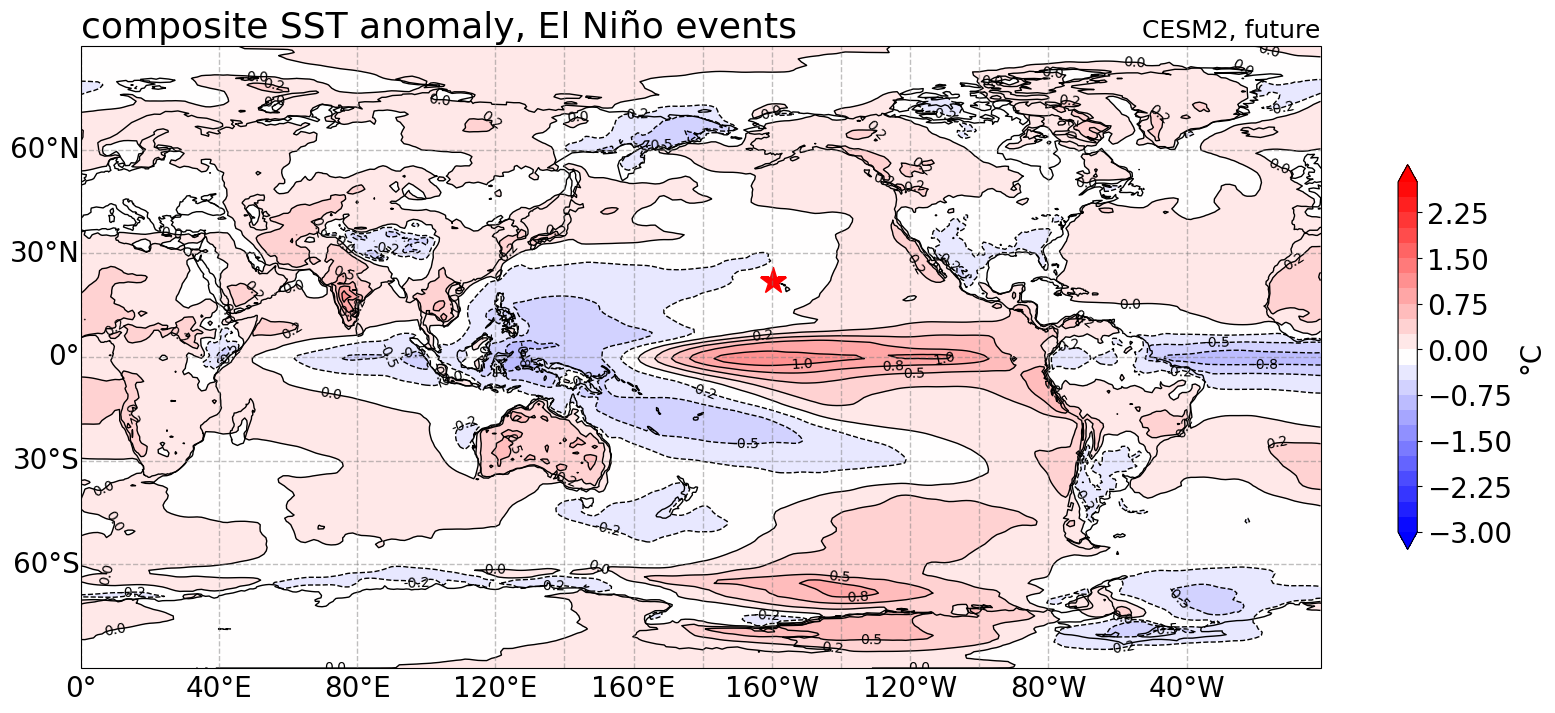

In [77]:
# then, select and plot the average for the label: nino. 
# This is the composite SST anomaly for all El Niño events in this model's FUTURE simulation. 
nino_composite_future=sst_composites_future.sel(label='nino')
# Plot the El Nino composite: 
lon=nino_composite_future.lon
lat=nino_composite_future.lat
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(-3, 3, 0.25)
# filled contours
cf = ax.contourf(lon, lat, nino_composite_future, cmap='bwr',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, nino_composite_future, colors='k', linewidths=1,levels=levels,
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=10, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('', fontsize=14)
cb.set_label(u'\N{DEGREE SIGN}C', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('composite SST anomaly, El Niño events', loc='left', fontsize=26)
plt.title('CESM2, future', loc='right', fontsize=18)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 140, 160, 180, -160, -140, -120, -100, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}
ax.plot(-159.5261,22.0964,  markersize=20, marker='*', color='red',transform=ccrs.PlateCarree(),alpha=1)  # this is a way to add a marker on the plot. Put a marker for your hometown!  # 
plt.savefig('ElNinoComposite_CESM2future.pdf')  
plt.show()

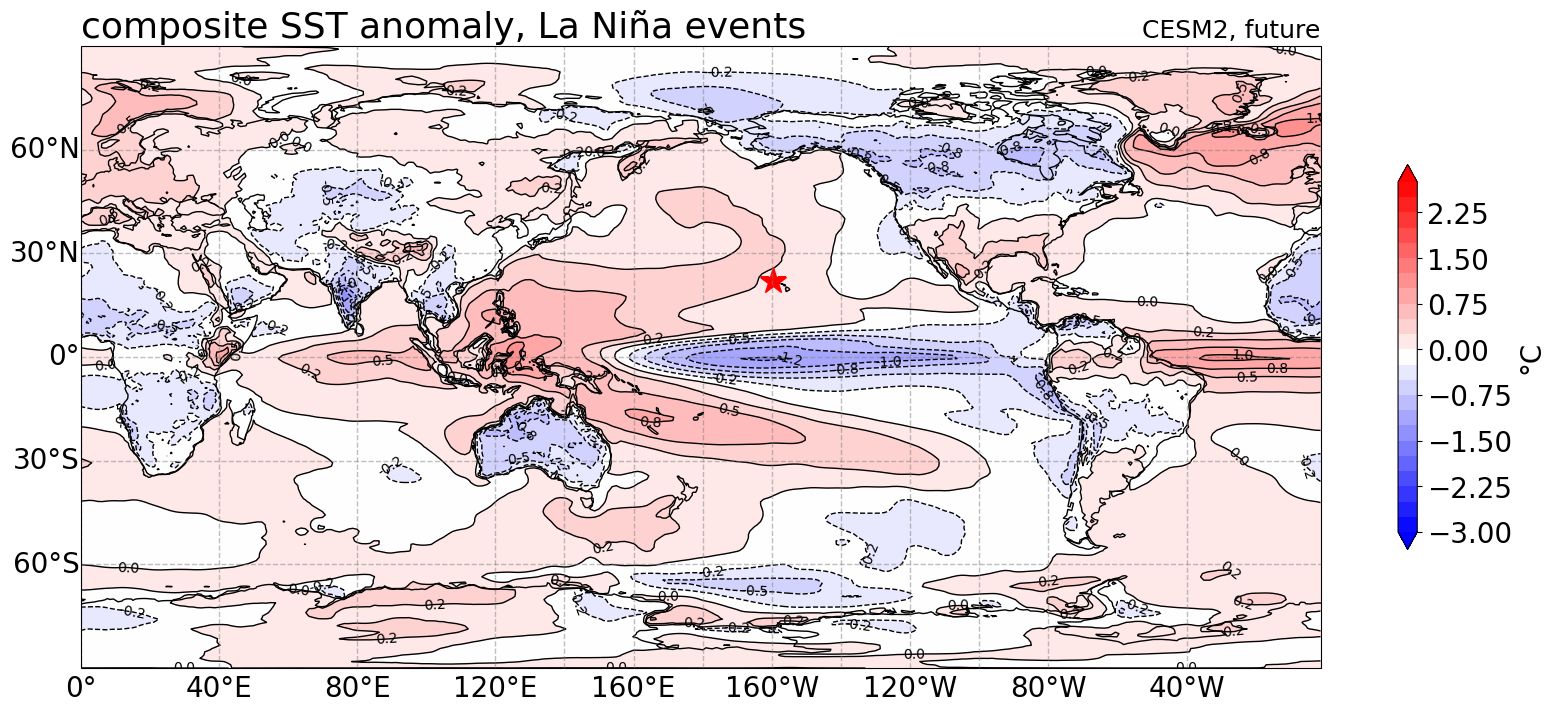

In [78]:
# then, select and plot the average for the label: nina. 
# This is the composite SST anomaly for all La Nina events in this model's FUTURE simulation. 
# Repeat for La Niña conditions: 
nina_composite_future=sst_composites_future.sel(label='nina')
# Plot the La Nina composite 
lon=nina_composite_future.lon
lat=nina_composite_future.lat
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(-3, 3, 0.25)
# filled contours
cf = ax.contourf(lon, lat, nina_composite_future, cmap='bwr',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, nina_composite_future, colors='k', linewidths=1,levels=levels,
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=10, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('', fontsize=14)
cb.set_label(u'\N{DEGREE SIGN}C', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('composite SST anomaly, La Niña events', loc='left', fontsize=26)
plt.title('CESM2, future', loc='right', fontsize=18)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 140, 160, 180, -160, -140, -120, -100, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}
ax.plot(-159.5261,22.0964,  markersize=20, marker='*', color='red',transform=ccrs.PlateCarree(),alpha=1)  # this is a way to add a marker on the plot. Put a marker for your hometown!  # 
plt.savefig('LaNinaComposite_CESM2future.pdf')  
plt.show()

----------------------
## ENSO impacts (precipitation teleconnections) in the future simulations

We have already loaded the precipitation dataset from the future simulation. **It is called dpr_future**. Now, you need to load the precipitation data, detrend them, like we did for sst, compute the climatology and the anomalies and then correlate with the ONI (future) index, in order to produce the ENSO teleconnection figure for the future simulation. 

In [79]:
# find the code from the historical analysis that reads in precipitation and converts the units to mm/day. 
# Copy it here and change the name of the dataset from the historical to the future one. 
pr_future = dpr_future.pr *86400           #converting units to mm/day
pr_future.attrs = dpr_future.pr.attrs       # copy the variable attributes (metadata) from the original pr variable
pr_future.attrs ['units'] = 'mm/day'         # change the units in the metadata to mm/day
pr_future

<xarray.DataArray 'pr' (time: 1032, lat: 192, lon: 288)>
dask.array<mul, shape=(1032, 192, 288), dtype=float64, chunksize=(288, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        chunits( ((1000 * PRECT)), units="kg m-2 s-1")
    description:    at surface; includes both liquid and solid phases from al...
    frequency:      mon
    id:             pr
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Precipitation
    type:           real
    units:          mm/day
    variable_id:    pr

Then, we need to detrend the precipitation data.

In [80]:
#find the code we used to detrend the sst data and copy it here. 
#Adapt it for the precipitation data (i.e., change the variable names from sst to precipitation)
# This will create a detrended precipitation dataset from the future simulation, called pr_future_detrend
pr_future=pr_future.load()
pr_future_detrend_data=signal.detrend(pr_future)      # detrend the temperature data
pr_future_detrend=pr_future.copy(data=pr_future_detrend_data) #create a new dataset, fill in with the detrended data.
pr_future_detrend=pr_future_detrend+pr_future.mean(dim='time')    #we add the mean to the detrended data

Now, use the detrended precipitation dataset to compute the climatology and compute the anomalies, in the same way that we did for sst. 

In [81]:
# Find the code that we used to create sst (ts) climatology and anomalies from the future run. 
# Adapt it for precipitation (i.e., instead of ts, your variable name now is pr)
# In the end, you should have a dataset of precipitation anomalies in the future, called pr_anom_future
# compute climatology and anomalies
pr_for_clim_future=pr_future.sel(time=slice('2024-01-01','2053-12-01'))
pr_for_clim_future
pr_clim_future = pr_for_clim_future.groupby('time.month').mean(dim='time')
pr_clim_future
pr_anom_future = pr_future.groupby('time.month') - pr_clim_future
pr_anom_future

<xarray.DataArray 'pr' (time: 1032, lat: 192, lon: 288)>
array([[[ 2.31411453e-02,  2.31371688e-02,  2.31406597e-02, ...,
          2.31362933e-02,  2.31400460e-02,  2.31422953e-02],
        [-1.82974163e-04, -1.07421620e-03, -2.12242066e-03, ...,
          2.14258356e-03,  1.57020811e-03,  9.98893174e-04],
        [-1.12226884e-02, -6.85271776e-03, -2.30208414e-03, ...,
         -1.91669257e-02, -1.73043376e-02, -1.46246862e-02],
        ...,
        [-2.35623319e-01, -2.41304865e-01, -2.47815119e-01, ...,
         -2.15916342e-01, -2.23287502e-01, -2.29868795e-01],
        [-3.84298735e-01, -3.87129495e-01, -3.90200662e-01, ...,
         -3.75986795e-01, -3.78407828e-01, -3.81390963e-01],
        [-3.82922316e-01, -3.82947509e-01, -3.82925166e-01, ...,
         -3.82952754e-01, -3.82916286e-01, -3.82937711e-01]],

       [[-3.18291498e-02, -3.18281857e-02, -3.18286359e-02, ...,
         -3.18288733e-02, -3.18308978e-02, -3.18296236e-02],
        [-2.60996894e-02, -2.65247042e-02, -2.72456406e-02, ...,
         -2.41556475e-02, -2.53871529e-02, -2.58088448e-02],
        [-9.97580228e-03, -8.61693685e-03, -7.92652289e-03, ...,
         -1.30735229e-02, -1.24512671e-02, -1.14521775e-02],
...
        [-1.55934910e-02, -1.46589454e-02, -3.60483391e-03, ...,
         -1.67647716e-02, -1.84622209e-02, -1.71686077e-02],
        [ 3.19066892e-01,  3.09344744e-01,  3.02728360e-01, ...,
          3.50478036e-01,  3.41015597e-01,  3.29956738e-01],
        [ 3.15163873e-01,  3.15231971e-01,  3.15257813e-01, ...,
          3.15246734e-01,  3.15245744e-01,  3.15308601e-01]],

       [[-3.68434269e-02, -3.68435271e-02, -3.68433480e-02, ...,
         -3.68434356e-02, -3.68432524e-02, -3.68433904e-02],
        [-7.99372677e-02, -7.82322610e-02, -7.65442052e-02, ...,
         -8.16420047e-02, -8.11607769e-02, -8.06539200e-02],
        [-6.40907570e-02, -5.93094625e-02, -5.46307459e-02, ...,
         -8.10080963e-02, -7.42615424e-02, -6.86603074e-02],
        ...,
        [ 5.05304958e-01,  5.09984295e-01,  5.15816959e-01, ...,
          5.19120045e-01,  5.13408980e-01,  5.06718043e-01],
        [ 6.71236729e-01,  6.71103414e-01,  6.72868610e-01, ...,
          6.73401232e-01,  6.70023380e-01,  6.68336885e-01],
        [ 5.74863485e-01,  5.74857225e-01,  5.74896630e-01, ...,
          5.74898854e-01,  5.74855040e-01,  5.74832209e-01]]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

Now, we will correlate the precipitation anomalies from the future run with the ONI from the future run. This will give us the ENSO teleconnection pattern. 

In [82]:
# find the code we used in the historical analysis to correlate precipitation anomalies with the ONI Index. 
# Copy it below. 
# Change the variables from historical to the future ones. 
# You should end up with a data array called precip_cor_future
precip_cor_future = xr.corr(pr_anom_future,oni_future,dim='time')                     # calculate the correlation between precipitation anomalies and ONI
precip_cor_future                                                                 # the resulting array containing the correlation coefficients

<xarray.DataArray (lat: 192, lon: 288)>
array([[0.09860351, 0.09860273, 0.09860034, ..., 0.09860351, 0.09860269,
        0.09860395],
       [0.09125883, 0.09197883, 0.09273166, ..., 0.08930193, 0.09015126,
        0.09063158],
       [0.07436294, 0.07538361, 0.07665582, ..., 0.07262836, 0.073131  ,
        0.07349047],
       ...,
       [0.02723813, 0.02614305, 0.0253655 , ..., 0.02897262, 0.02845707,
        0.02783102],
       [0.01000294, 0.00993523, 0.00944751, ..., 0.01124252, 0.01090691,
        0.01023179],
       [0.01348395, 0.0134837 , 0.01345853, ..., 0.01352677, 0.01347939,
        0.01352847]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

Now, take the code that we used to plot the ENSO-precipitation correlation pattern (teleconnection) and adapt it to plot the correlation from the future run. 

You have to compare the new figure (future ENSO precipitation correlation) with the historical one, and discuss what changes you see. ** This will answer Question 8 (Part 2) of your assignment. **

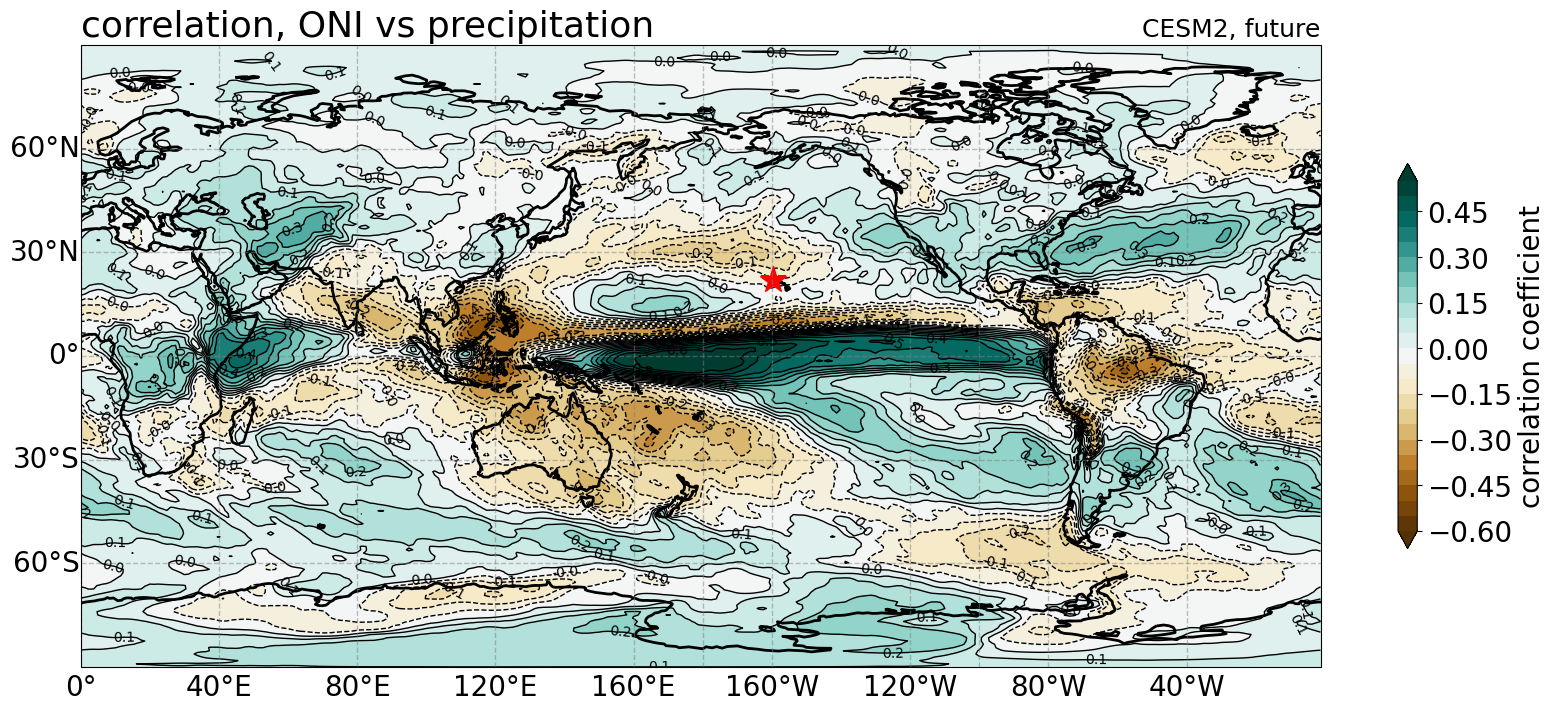

In [83]:
# find the code we used in the historical analysis to plot the ENSO precipitation teleconnection pattern. 
# Copy it below. 
# Change the correlation from historical to future.
# Plot the correlation map: 
lon=precip_cor_future.lon
lat=precip_cor_future.lat
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(-0.6, 0.6, 0.05)
# filled contours
cf = ax.contourf(lon, lat, precip_cor_future, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, precip_cor_future, colors='k', linewidths=1,levels=levels,
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=10, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('', fontsize=14)
cb.set_label('correlation coefficient', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('correlation, ONI vs precipitation', loc='left', fontsize=26)
plt.title('CESM2, future', loc='right', fontsize=18)
ax.coastlines(linewidth=2)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 160, 180, -160, -120, -100, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}
ax.plot(-159.5261,22.0964,  markersize=20, marker='*', color='red',transform=ccrs.PlateCarree(),alpha=1)  # this is a way to add a marker on the plot. Put a marker for your hometown!  # 
plt.savefig('ENSO_precipitation_correlation_CESM2_future.pdf')  
plt.show()

**Take all the plots you created, combine then in a ppt or pdf file and upload them to answer Question 5 of your assignment. **

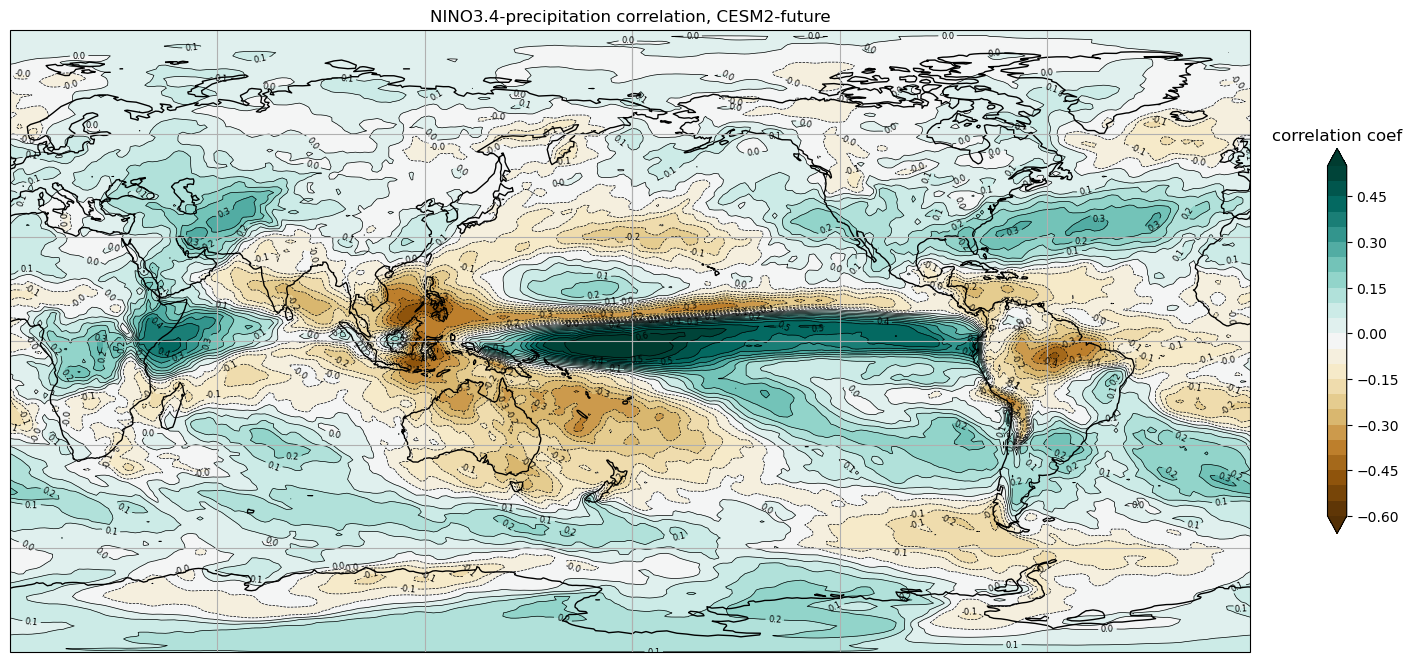

In [84]:
lon=precip_cor_future.lon
lat=precip_cor_future.lat
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(-0.6, 0.6, 0.05)
# filled contours
cf = ax.contourf(lon, lat, precip_cor_future, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, precip_cor_future, colors='k', linewidths=0.5,levels=levels,
                transform=ccrs.PlateCarree())

# add contour labels
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%0.1f');


# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('correlation coef')
ax.set_title('NINO3.4-precipitation correlation, CESM2-future');
ax.coastlines()
ax.gridlines()


# END